In [1]:
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import math
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

log_plot = True

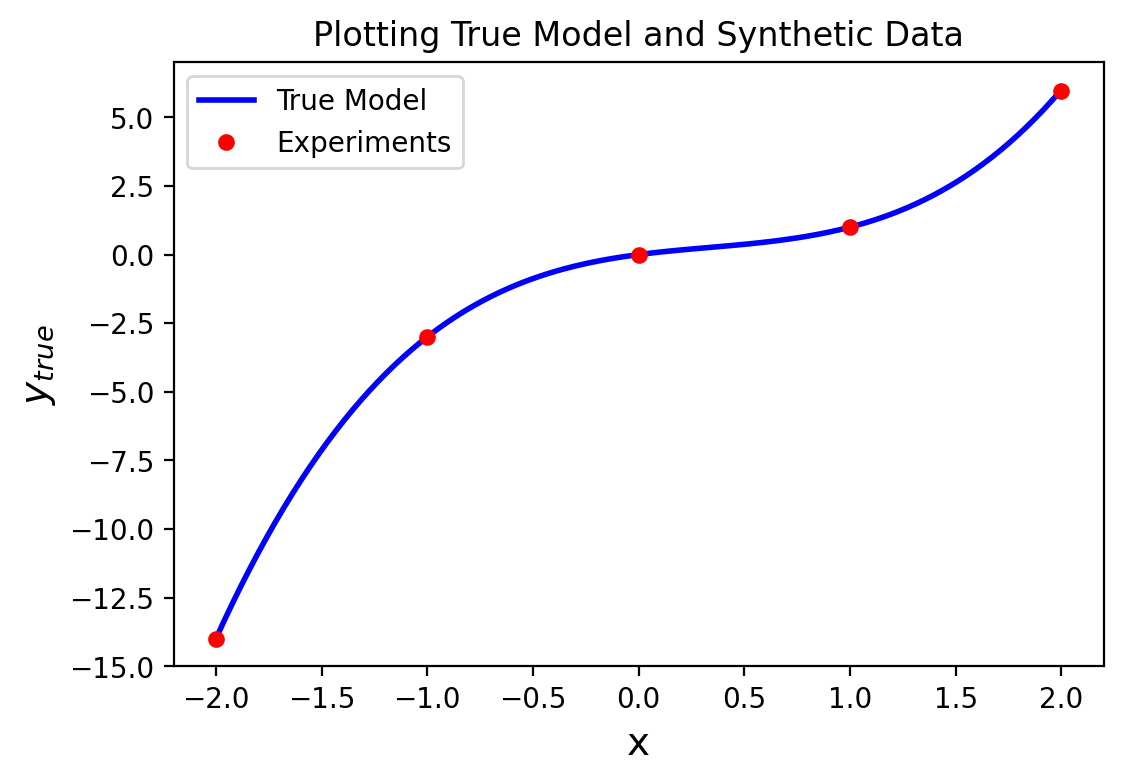

[-14.  -3.   0.   1.   6.]
CPU times: user 415 ms, sys: 41.4 ms, total: 457 ms
Wall time: 470 ms


In [2]:
%%time
# Create synthetic data assuming the following values for theta
Theta_Guess = np.array([1,-1])

##New Cell

# Evaluate model and add noise based on assumed theta values
# This generates experimental data points
exp_data_doc = "Input_CSVs/Exp_Data/n=5.csv"
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]

##New Cell

# Evaluate model based on the assumed experimental values
X = np.linspace(np.min(Xexp),np.max(Xexp),100)
Y = Theta_Guess[0]*X + Theta_Guess[1]*X**2 + X**3

# Compare the experiments to the true model
plt.plot(X,Y,'b-',linewidth=2,label="True Model")
plt.plot(Xexp,Yexp,'r.',markersize=10,label="Experiments")
plt.title("Plotting True Model and Synthetic Data")
plt.xlabel('x',fontsize=14)
plt.ylabel('$y_{true}$',fontsize=14)
plt.legend()
plt.show()

##New Cell

## define function that includes nonlinear model
def model(theta,x):
    '''
    Toy model
    Arguments:
        theta: parameter vector
        x: independent variable vector
    Returns:
        y_model: dependent variable prediction
    '''
    y_model = theta[0]*x + theta[1]*x**2 + x**3
    return y_model

print(model(Theta_Guess,Xexp))

##New Cell

# Create a function to optimize, in this case, least squares fitting
def regression_func(theta, x, y):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        theta: parameter vector
        x: independent variable vector
        y: dependent variable vector (measurements)
    Returns:
        e: residual vector
    '''
    
    error = y - model(theta,x); #NOTE: Least squares will calculate sse based off this to minimize
    
    return error
#New Cell

#Create a function to define the SSE for any Theta vector on a heat map.
def sse_func(xx, yy, x, y):
    '''
    Function to define define sum of squared error function for heat map
    Arguments:
        xx: An N X D array of all Theta1 values
            
        yy: An D X N array of all Theta2 values
        theta: parameter vector
        x: independent variable vector (predicted x values including noise)
        y: dependent variable vector (predicted y values on Heat Map)
    Returns:
        sse: N x N sum of squared error matrix of all generated combination of xx and yy
    '''
    sse = np.zeros([len(xx),len(yy)])
    
    for i in range(len(xx)):
        for j in range(len(yy)):
            theta = np.array([xx[i][j],yy[i][j]])
            sse[i][j] = sum((y - model(theta,x))**2) 
    
    return sse

In [15]:
%%time
#New Cell

## specify initial guess
# sse_list = []
# for i in range(15):
theta0 = np.random.rand(2) * (2+2) -2
#     theta0 = Theta_Guess
#     print(theta0)

## specify bounds
# first array: lower bounds
# second array: upper bounds
bounds = ([-np.inf, -np.inf], [np.inf, np.inf])

## use least squares optimizer in scipy
# argument 1: function that takes theta as input, returns residual
# argument 2: initial guess for theta
# optional arguments 'bounds': bounds for theta
# optional arugment 'args': additional arguments to pass to residual function
# optional argument 'method': select the numerical method
#   if you want to consider bounds, choose 'trf'
#   if you do not want to consider bounds, try either 'lm' or 'trf'
Solution = optimize.least_squares(regression_func, theta0,bounds=bounds, method='trf',args=(Xexp, Yexp),verbose=2)

theta = Solution.x
print("theta = ",theta)
    
#     Y_pred2 = model(theta,Xexp)
#     error = (Yexp - Y_pred2)
#     sse_list.append(np.sum(error**2))

# sse_list = np.array(sse_list)
# print(np.median(sse_list))
# print(np.argmin(sse_list))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5174e+00                                    9.93e+00    
       1              2         1.4815e-05      1.52e+00       3.14e-01       5.71e-08    
       2              3         1.4815e-05      9.41e-17       3.46e-09       2.00e-15    
`gtol` termination condition is satisfied.
Function evaluations 3, initial cost 1.5174e+00, final cost 1.4815e-05, first-order optimality 2.00e-15.
theta =  [ 0.99402191 -1.00334245]
CPU times: user 3.81 ms, sys: 131 µs, total: 3.94 ms
Wall time: 3.03 ms


In [ ]:
#New Cell

# generate predictions
X_pred = np.linspace(np.min(Xexp),np.max(Xexp),20)
Y_pred = model(theta, X_pred)

Theta1_Map = np.linspace(-2,2,100)
Theta2_Map = np.linspace(-2,2,100)

x = Theta1_Map
y = Theta2_Map

# full coorindate arrays
xx, yy = np.meshgrid(x, y)
zz = sse_func(xx,yy,X_pred,Y_pred)

if log_plot == True:
    zz = np.log(zz)

plt.figure(figsize = (6,6))

cs = plt.contourf(xx, yy,zz, levels = 100, cmap = "autumn")

# plot color bar
if np.amax(zz) < 1e-1:
    cbar = plt.colorbar(cs, format='%.2e')
else:
    cbar = plt.colorbar(cs, format = '%2.2f')

# plot title in color bar
cbar.ax.set_ylabel(r'$\mathbf{log(e(\theta))}$', fontsize=16, fontweight='bold')
#     print(p_GP_opt[0],p_GP_opt[1])

# set font size in color bar
cbar.ax.tick_params(labelsize=16)

# Plot equipotential line
cs2 = plt.contour(cs, levels=cs.levels[::10], colors='k', alpha=0.7, linestyles='dashed', linewidths=3)

if np.amax(zz) < 1e-1:
    plt.clabel(cs2, fmt='%.2e', colors='k', fontsize=16)
else:
    plt.clabel(cs2, fmt='%2.2f', colors='k', fontsize=16)

plt.scatter(Theta_Guess[0],Theta_Guess[1], color="blue", s=100, label = "True Optimal Value", marker = (5,1))
plt.scatter(theta[0],theta[1], color="white",s=50, marker = ".",label = "NLR Optimal Value", edgecolor = "k", linewidth=0.3)
# plt.grid()

plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0, loc = "lower right")
plt.xlabel(r'$\mathbf{\theta_1}$',fontsize=16,fontweight='bold')
plt.ylabel(r'$\mathbf{\theta_2}$',fontsize=16,fontweight='bold')
plt.xlim((np.amin(xx), np.amax(xx)))
plt.ylim((np.amin(yy),np.amax(yy)))   
plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
plt.axis('square')

if log_plot == True:
#     plt.title('NLR ln(SSE)', weight='bold',fontsize = 16)
    plt.savefig("Figures/NLR_ln(SSE).png", dpi=300, bbox_inches='tight')
else:
#     plt.title('Non-Linear Regression SSE', weight='bold',fontsize = 16)
    plt.savefig("Figures/NLR_SSE.png", dpi=300, bbox_inches='tight')
    

plt.show()
#New Cell

# create plot and compare predictions and experiments
plt.figure(figsize = (6.4,4))
plt.plot(Xexp,Yexp,'.g',markersize=20,label='Experimental Data')
plt.plot(X,Y,'r-',linewidth=3,label='$y_{exp}$')
plt.plot(X_pred,Y_pred,'--b',linewidth=4,label='$y_{sim}$; $\\theta = [-0.994,1.00]$')
# plt.title("Predictions with $\\theta = [-0.994,1.00]$ vs Syntehic Data")
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0, loc = "upper left")
plt.xlabel(r'$\mathbf{x}$',fontsize=16,fontweight='bold')
plt.ylabel(r'$\mathbf{y_{sim}}$',fontsize=16,fontweight='bold')

plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
# plt.grid(True)

plt.savefig("Figures/sim_true_comp.png", dpi=300, bbox_inches='tight')
plt.show()


##New Cell

#Plot error
Y_pred2 = model(theta,Xexp)
error = (Yexp - Y_pred2)
print("SSE = ", np.sum(error**2))
plt.plot(Y_pred2,error,"b.",markersize=20, label = "Error")
plt.title("Residuals")
plt.xlabel('Predicted Y')
plt.ylabel('Residuals vs. Predicted Value')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#Jacobian and Uncertainty Analysis
print("Jacobian =\n")
print(Solution.jac)
sigre = (error.T @ error)/(len(error) - 2)
Sigma_theta2 = sigre * np.linalg.inv(Solution.jac.T @ Solution.jac)
print("Covariance matrix:\n",Sigma_theta2)